### Figure 5: Power Spectra at each wave number

In [1]:
import numpy as np
# from esda.moran import Moran,Moran_Local
# from libpysal.weights import lat2W
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
# import properscoring as ps
import warnings
from scipy import stats
import scipy.stats as stats
from scipy import interpolate
# from utils.evaluation import plot_histogram,calc_peak,calc_mean
# https://bertvandenbroucke.netlify.app/2019/05/24/computing-a-power-spectrum-in-python/
from sklearn.metrics import mean_squared_error
from math import sqrt
from utils.data import load_tc_data
import xesmf as xe
warnings.filterwarnings("ignore")
# sns.set_style("white")
sns.set_palette(sns.color_palette("Paired"))

In [2]:
def power_spectrum_dB(img):
	fx = np.fft.fft2(img)
	fx = fx[:img.shape[0]//2, :img.shape[1]//2] # disgard half of it because you can derive one half from the other?
	px = abs(fx)**2 # get the size of the amplitudes
	return 10 * np.log10(px) # is this the rainfall normalisation step?

def power_spectrum_dB_2(img):
	fx = np.fft.fft2(img)
	# fx = fx[:img.shape[0]//2, :img.shape[1]//2] # disgard half of it because you can derive one half from the other?
	px = abs(fx)**2 # get the size of the amplitudes
	return px

def log_spectral_batch(batch1):
	lsd_batch = []
	for i in range(batch1.shape[0]):
		lsd = power_spectrum_dB_2(
				batch1[i, :, :])
		lsd_batch.append(lsd)
	return np.array(lsd_batch)

In [3]:
def plot_power_spectrum(spectral_density,plot=True):
    """
    spectral density should probably be a 100x100 image
    """
	# https://bertvandenbroucke.netlify.app/2019/05/24/computing-a-power-spectrum-in-python/
    npix=100

    # return a one dimensional array containing the wave vectors for the numpy.fft.fftn call, in the correct order.
    kfreq = np.fft.fftfreq(npix) * npix
    
    # convert this to a two dimensional array matching the layout of the two dimensional Fourier image, we can use numpy.meshgrid
    kfreq2D = np.meshgrid(kfreq, kfreq)
    
    # Finally, we are not really interested in the actual wave vectors, but rather in their norm
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)

    # we no longer need the wave vector norms or Fourier image to be laid out as a two dimensional array, so we will flatten them
    knrm = knrm.flatten()
    fourier_amplitudes = spectral_density
    fourier_amplitudes = fourier_amplitudes.flatten()

    # bin the amplitudes in k space, we need to set up wave number bins
    # Note that the maximum wave number will equal half the pixel size of the image. 
    # This is because half of the Fourier frequencies can be mapped back to negative wave
    #  numbers that have the same norm as their positive counterpart.
    kbins = np.arange(0.5, npix//2+1, 1.)

    # The kbin array will contain the start and end points of all bins; the corresponding k values are the midpoints of these bins
    kvals = 0.5 * (kbins[1:] + kbins[:-1])

    # To compute the average Fourier amplitude (squared) in each bin, we can use scipy.stats
    Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes,
                                        statistic = "mean",
                                        bins = kbins)

    # Remember that we want the total variance within each bin. Right now, we only have the average power. To get the total power, we need to multiply with the volume in each bin (in 2D, this volume is actually a surface area)
    Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)

    if plot == True:
        plt.loglog(kvals, Abins)
        plt.show
    else:
        return kvals,Abins
    

In [4]:
def calc_power(lsb_pred):
	kvals_list = []
	Abins_list = []

	for lsb in lsb_pred:
		kvals,Abins = plot_power_spectrum(lsb,plot=False)
		kvals_list.append(kvals)
		Abins_list.append(Abins)

	kvals = np.array(kvals_list)
	Abins = np.array(Abins_list)
	return kvals,Abins


In [5]:
def mean_power(kvals,Abins):

	xnew = np.sort(kvals.flatten())
	Y = np.zeros((Abins.shape[0],len(xnew)))
	for i,y in enumerate(Abins):
		x = kvals[i]	
		f = interpolate.interp1d(x, y,bounds_error=False)
		ynew = f(xnew)
		print(ynew.shape)
		print('xnew shape',xnew.shape)
		Y[i] = ynew
	print(xnew.shape)
	print(Y.shape)
	# split up to process the mean
	Y_mean_1 = np.nanmean(Y[0:5000],axis=0)
	Y_mean_2 = np.nanmean(Y[5000:10000],axis=0)
	Y_mean_3 = np.nanmean(Y[10000:],axis=0)
	Y_mean = np.nanmean([Y_mean_1,Y_mean_2,Y_mean_3],axis=0)
	print(Y_mean.shape)
	# kvals = x, Abins = Y_mean
	return(xnew,Y_mean)

In [6]:
def spectral_power_process(data):
	lsb = log_spectral_batch(data[:,:,:,0])
	kvals,Abins = calc_power(lsb)
	k,p_k = kvals[0],np.mean(Abins,axis=0)
	return k,p_k
	

In [7]:
# model = ''
# set mode
# mode = 'validation'

# load datasets
real,inputs,pred,meta = load_tc_data(set='validation',results='ke_tracks')
real_2,inputs_2,pred_2,meta_2,inputs_og,pred_og,meta_og = load_tc_data(set='validation',results='kh_tracks')
meta_og = pd.read_csv('/user/work/al18709/tc_data_mswep_40/valid_meta.csv')
modular_pred_2 = np.load('/user/home/al18709/work/gan_predictions_20/modular_part2_pred-opt_modular_test.npy')
meta_valid = pd.read_csv('/user/work/al18709/tc_data_flipped/valid_meta.csv')
pred_mraw = np.load('/user/home/al18709/work/gan_predictions_20/validation_pred-opt_modular_part2_raw.npy')


In [8]:
# load imerg
imerg_rain = np.load('/user/home/al18709/work/CMIP6/IMERG-V07/storm_rain/storm_rain_NH.npy')

In [9]:
# load HighResMIP CMCC-CM2-VHR4 historical NH
CMCC_hist_NH_rain = np.load('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/historical/storm_rain_NH.npy')

# load HighResMIP CMCC-CM2-VHR4 historical SH
CMCC_hist_SH_rain = np.load('/user/home/al18709/work/CMIP6/HighResMIP/CMCC-CM2-VHR4/storm_rain/historical/storm_rain_SH.npy')


In [10]:
# load HighResMIP HadGEM3-GC31-HM   historical NH
hadgem_hist_NH_rain = np.load('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/historical/storm_rain_NH.npy')

# # load HighResMIP HadGEM3-GC31-HM  historical SH
hadgem_hist_SH_rain = np.load('/user/home/al18709/work/CMIP6/HighResMIP/HadGEM3-GC31-HM/storm_rain/historical/storm_rain_SH.npy')


In [11]:
# load CMIP6 historical dataset 
miroc6_hist_rain = np.load('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/historical/storm_rain_NH.npy')
miroc6_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/MIROC6/storm_rain/historical/storm_rain_SH.npy')

# CMIP6 MPI-ESM1-2-LR
mpi_hist_rain = np.load('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/historical/storm_rain_NH.npy')
mpi_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/MPI-ESM1-2-LR/storm_rain/historical/storm_rain_SH.npy')

# CMIP6 Noresm
noresm_hist_rain = np.load('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/historical/storm_rain_NH.npy')
noresm_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/NorESM2-LM/storm_rain/historical/storm_rain_SH.npy')

# CMIP6 IPSL
ipsl_hist_rain = np.load('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/historical/storm_rain_NH.npy')
ipsl_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/IPSL-CM6A-LR/storm_rain/historical/storm_rain_SH.npy')

# CMIP6 mri
mri_hist_rain = np.load('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/historical/storm_rain_NH.npy')
mri_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/MRI-ESM2-0/storm_rain/historical/storm_rain_SH.npy')

# CMIP6 EC-Earth
ecearth_hist_rain = np.load('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/historical/storm_rain_NH.npy')
ecearth_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/EC-Earth3/storm_rain/historical/storm_rain_SH.npy')

# CMIP6 CMCC_LR
cmcclr_hist_rain = np.load('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/historical/storm_rain_NH.npy')
cmcclr_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/CMCC-ESM2/storm_rain/historical/storm_rain_SH.npy')

# CMIP6 NESM3
nesm_hist_rain = np.load('/user/home/al18709/work/CMIP6/NESM3/storm_rain/historical/storm_rain_NH.npy')
nesm_hist_rain_SH = np.load('/user/home/al18709/work/CMIP6/NESM3/storm_rain/historical/storm_rain_SH.npy')


In [12]:
real_k,real_p_k = spectral_power_process(real)
wgan_scalar_k,wgan_scalar_p_k = spectral_power_process(pred)
wgan_modular_k,wgan_modular_p_k = spectral_power_process(modular_pred_2)
wgan_2d_k,wgan_2d_p_k = spectral_power_process(pred_og)
imerg_k,imerg_p_k = spectral_power_process(np.expand_dims(imerg_rain,axis=-1))
mraw_k,mraw_p_k = spectral_power_process(pred_mraw)


In [26]:
del real
del pred
del modular_pred_2
del pred_og
del imerg_rain
del pred_mraw


In [13]:
# cmcchr_nh_k,cmcchr_nh_p_k = spectral_power_process(np.expand_dims(CMCC_hist_NH_rain,axis=-1))
# cmcchr_sh_k,cmcchr_sh_p_k = spectral_power_process(np.expand_dims(CMCC_hist_SH_rain,axis=-1))
# hadgem_nh_k,hadgem_nh_p_k = spectral_power_process(np.expand_dims(hadgem_hist_NH_rain,axis=-1))
# hadgem_sh_k,hadgem_sh_p_k = spectral_power_process(np.expand_dims(hadgem_hist_SH_rain,axis=-1))

hrmip_k,hrmip_p_k = spectral_power_process(np.expand_dims(np.concatenate((CMCC_hist_NH_rain,CMCC_hist_SH_rain,hadgem_hist_NH_rain,hadgem_hist_SH_rain),axis=0),axis=-1))

In [14]:
# miroc6_nh_k,miroc6_nh_p_k = spectral_power_process(np.expand_dims(miroc6_hist_rain,axis=-1))
# miroc6_sh_k,miroc6_sh_p_k = spectral_power_process(np.expand_dims(miroc6_hist_rain_SH,axis=-1))

# mpi_nh_k,mpi_nh_p_k = spectral_power_process(np.expand_dims(mpi_hist_rain,axis=-1))
# mpi_sh_k,mpi_sh_p_k = spectral_power_process(np.expand_dims(mpi_hist_rain_SH,axis=-1))

# noresm_nh_k,noresm_nh_p_k = spectral_power_process(np.expand_dims(noresm_hist_rain,axis=-1))
# noresm_sh_k,noresm_sh_p_k = spectral_power_process(np.expand_dims(noresm_hist_rain_SH,axis=-1))

# ipsl_nh_k,ipsl_nh_p_k = spectral_power_process(np.expand_dims(ipsl_hist_rain,axis=-1))
# ipsl_sh_k,ipsl_sh_p_k = spectral_power_process(np.expand_dims(ipsl_hist_rain_SH,axis=-1))

# mri_nh_k,mri_nh_p_k = spectral_power_process(np.expand_dims(mri_hist_rain,axis=-1))
# mri_sh_k,mri_sh_p_k = spectral_power_process(np.expand_dims(mri_hist_rain_SH,axis=-1))

# ecearth_nh_k,ecearth_nh_p_k = spectral_power_process(np.expand_dims(ecearth_hist_rain,axis=-1))
# ecearth_sh_k,ecearth_sh_p_k = spectral_power_process(np.expand_dims(ecearth_hist_rain_SH,axis=-1))

# cmcclr_nh_k,cmcclr_nh_p_k = spectral_power_process(np.expand_dims(cmcclr_hist_rain,axis=-1))
# cmcclr_sh_k,cmcclr_sh_p_k = spectral_power_process(np.expand_dims(cmcclr_hist_rain_SH,axis=-1))

# nesm_nh_k,nesm_nh_p_k = spectral_power_process(np.expand_dims(nesm_hist_rain,axis=-1))
# nesm_sh_k,nesm_sh_p_k = spectral_power_process(np.expand_dims(nesm_hist_rain_SH,axis=-1))


cmip_k,cmip_p_k = spectral_power_process(np.expand_dims(np.concatenate((miroc6_hist_rain,
																		miroc6_hist_rain_SH,
																		mpi_hist_rain,
																		mpi_hist_rain_SH,
																		noresm_hist_rain,
																		noresm_hist_rain_SH,
																		ipsl_hist_rain,
																		ipsl_hist_rain_SH,
																		mri_hist_rain,
																		ipsl_hist_rain_SH,
																		mri_hist_rain,
																		mri_hist_rain_SH,
																		ecearth_hist_rain,
																		ecearth_hist_rain_SH,
																		cmcclr_hist_rain,
																		cmcclr_hist_rain_SH,
																		nesm_hist_rain,
																		nesm_hist_rain_SH)
																	  ,axis=0),axis=-1))




In [15]:
# lsb_real = log_spectral_batch(real[:,:,:,0])
# lsb_gan = log_spectral_batch(pred[:,:,:,0])
# lsb_gan2 = log_spectral_batch(pred_2[:,:,:,0])
# lsb_ganog = log_spectral_batch(pred_og[:,:,:,0])
# print(lsb_real[0])


In [16]:
# kvals_real,Abins_real = calc_power(lsb_real)
# kvals_gan,Abins_gan = calc_power(lsb_gan)
# kvals_gan2,Abins_gan2 = calc_power(lsb_gan2)
# kvals_ganog,Abins_ganog = calc_power(lsb_ganog)

In [17]:
# plt.plot(xnew,Y_mean)
# # k,p_k = mean_power(kvals,Abins)
# # TODO: this takes way too long
# print(kvals_real[0])
# print(kvals_real[1])
# k_real,p_k_real = kvals_real[0],np.mean(Abins_real,axis=0)
# k_gan,p_k_gan = kvals_gan[0],np.mean(Abins_gan,axis=0)
# K_gan2,p_k_gan2 = kvals_gan2[0],np.mean(Abins_gan2,axis=0)
# K_ganog,p_k_ganog = kvals_ganog[0],np.mean(Abins_ganog,axis=0)


In [18]:
# k_gan_ensemble = np.zeros((20,50))
# p_k_gan_ensemble = np.zeros((20,50))
# for i in range(1):
# 	lsb_gan_i = log_spectral_batch(pred[:,:,:,i])
# 	kvals_gan_i,Abins_gan_i = calc_power(lsb_gan_i)
# 	k_gan,p_k_gan = kvals_gan[0],np.mean(Abins_gan,axis=0)
# 	k_gan_i,p_k_gan_i = kvals_gan[0],np.mean(Abins_gan_i,axis=0)
# 	k_gan_ensemble[i,:] = k_gan_i
# 	p_k_gan_ensemble[i,:] = p_k_gan_i


In [19]:
# k_gan_min,p_k_gan_min = k_gan_ensemble[0],np.min(p_k_gan_ensemble,axis=0)
# k_gan_max,p_k_gan_max = k_gan_ensemble[0],np.max(p_k_gan_ensemble,axis=0)

# k_gan_ensemble,p_k_gan_ensemble = k_gan_ensemble[0],np.mean(p_k_gan_ensemble,axis=0)


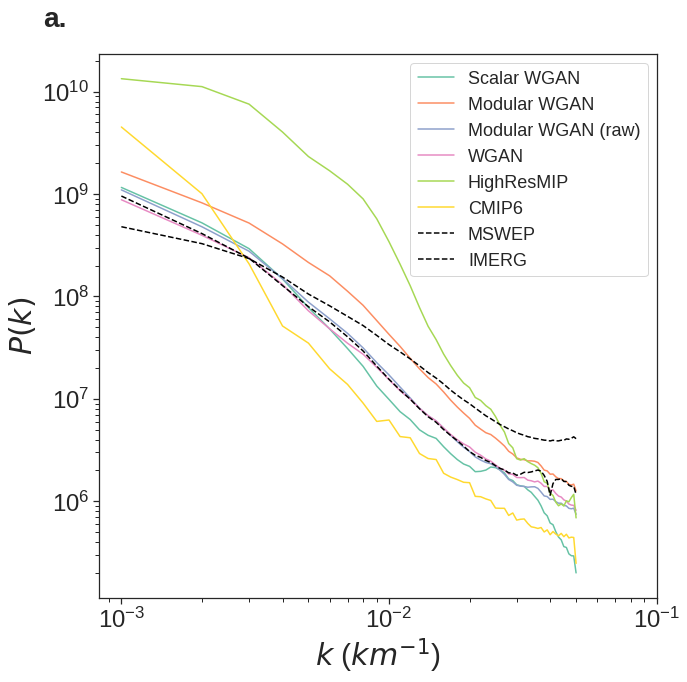

In [25]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10), sharey=False)
plt.style.use('seaborn-ticks')
plt.rcParams["figure.figsize"] = (10,10)
sns.set_context("notebook")
sns.set_palette("Set2")

def change_units(x):
	# npix * 1/k gives the units of pixels on the x axis
	# then we multiply by 10 because each pixel is 10km, the whole image is 1000km across
	# return 1000/x
	return x/1000

plt.loglog(change_units(wgan_scalar_k),wgan_scalar_p_k)
plt.loglog(change_units(wgan_modular_k),wgan_modular_p_k)
plt.loglog(change_units(mraw_k),mraw_p_k)
plt.loglog(change_units(wgan_2d_k),wgan_2d_p_k)
plt.loglog(change_units(hrmip_k),hrmip_p_k)
plt.loglog(change_units(cmip_k),cmip_p_k)


axes.text(-0.1, 1.05, 'a.', transform=axes.transAxes, size=28, weight='bold')
plt.loglog(change_units(real_k),real_p_k ,color='black',linestyle='dashed')
plt.loglog(change_units(imerg_k),imerg_p_k,color='black',linestyle='dashed')
plt.xlabel("$k$ ($km^{-1}$)",fontsize=30)
plt.xlim([0,0.1])
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.ylabel("$P(k)$",fontsize=30)
plt.legend(['Scalar WGAN','Modular WGAN','Modular WGAN (raw)','WGAN','HighResMIP','CMIP6','MSWEP','IMERG'],frameon=True,fontsize=18)
# plt.fill_between(k_vaegan_ensemble, p_k_vaegan_min,p_k_vaegan_max,color='#57cc99',alpha=0.2)
# plt.fill_between(k_gan_ensemble, p_k_gan_min,p_k_gan_max,color='#219ebc',alpha=0.2)
plt.savefig('figure5-power_spectra-ke_tracks_v31.png',bbox_inches='tight',dpi=600)
# plt.show

In [21]:
print()

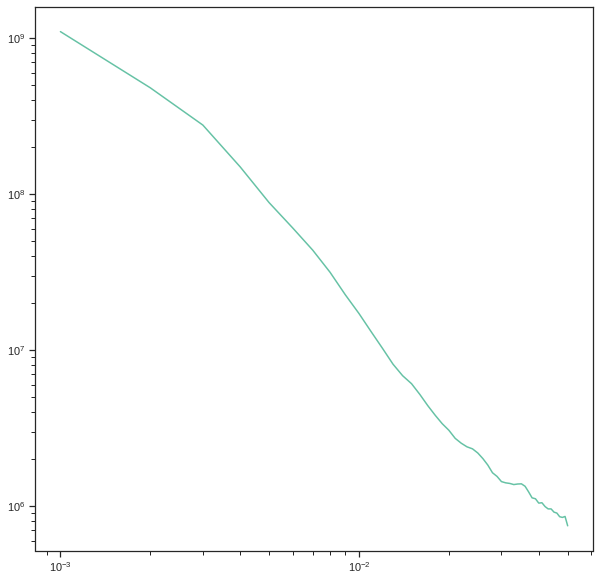

In [22]:
plt.loglog(change_units(mraw_k),mraw_p_k)

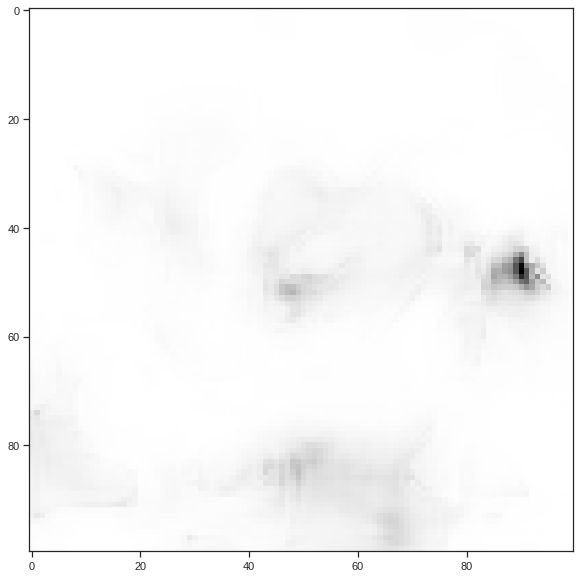

In [23]:
plt.imshow(pred_mraw[0,:,:,0])